# Лабораторная работа 5

Солодкая М.А. P4240

Полежаева Е.И. P4240

## Измерение сходства узлов на основе представления графа

В графовых нейронных сетях (Graph Neural Networks, GNN) одним из важных аспектов является измерение сходства между узлами графа.

Node Similarity представляет собой меру близости или похожести между двумя узлами графа. Измерение сходства узлов основывается на их представлениях в графе.
Схожесть узлов (Node Similarity) в графовых сетях представляет собой меру близости или похожести между двумя узлами графа. Измерение сходства узлов основывается на их представлениях в графе. Это понятие играет важную роль в анализе графов, так как позволяет выявлять связи и паттерны между узлами.

Когда речь идет о измерении схожести узлов в графовых сетях, можно использовать различные метрики. Три такие распространенные метрики — это Косинусная схожесть (Cosine Similarity), Манхэттенское расстояние (Manhattan Distance) и Евклидово расстояние (Euclidean Distance).


### Примеры метрик схожести узлов:

**Косинусная схожесть** (Cosine Similarity):


> Измеряет угол между векторами признаков узлов в графе, представляя их как многомерные векторы.

> $Cosine(A, B) = (Σ (A_i * B_i)) / (\sqrt(Σ A_i^2) * \sqrt(Σ B_i^2)), где A_i и B_i$ - значения признаков узлов.

**Манхэттенское расстояние** (Manhattan Distance):

> Измеряет сумму абсолютной разницы между соответствующими координатами узлов на графе.

> $Manh(A, B) = Σ |A_i - B_i|, где A_i и B_i$ - координаты узлов по каждой из размерностей.

**Евклидово расстояние** (Euclidean Distance):


> Измеряет расстояние между двумя узлами в графе, представляя их как точки в пространстве.

> $Euclid(A, B) = sqrt(Σ (A_i - B_i)^2), где A_i и B_i$ - координаты узлов по каждой из размерностей.




Использование этих метрик расстояния позволяет оценить геометрическое расположение узлов в графе.













### Установка зависимостей


Устанавливаем необходимые для работы зависимости

In [2]:
!pip install pykeen networkx matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.3/739.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 13.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.5 MB/s eta 0:00:00
  Created wheel for rexmex: filename=rexmex-0.1.3-py3-none-any.whl size=19952 sha256=f6cb4addd201e6adb735793b72168ab461eaa867f2156689c1bf8217321e9e38
  Stored in directory: /root/.cache/pip/wheels/13/31/9d/51fb64454e6012bc88dd72b57609646432e478ba35772736d6
Successfully built rexmex


Далее, импортируем необходимых модулей

In [3]:
import torch
import pykeen
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pykeen.pipeline import pipeline
from sklearn.neighbors import NearestNeighbors
from pykeen.evaluation import RankBasedEvaluator
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances

INFO:pykeen.utils:Using opt_einsum


Здесь мы устанавливаем необходимые библиотеки и импортируем модули, которые будут использоваться в лабораторной работе.

## Взаимодействие с графовым датасетом и описание данных

В данной работе мы будем использовать графовый датасет Countries.


Мы импортируем модуль datasets из Pykeen для работы с графовыми датасетами.

In [10]:
from pykeen.datasets import PharmKG8k

Загружаем графовый датасет Countries из Pykeen. В результате выполнения этой команды будет создан объект, представляющий графовый датасет.

In [11]:
# Загрузка графового датасета Countries
dbpedia_dataset = PharmKG8k()

Мы можем вывести описание датасета, чтобы получить информацию о количестве сущностей, отношений и других характеристиках.

In [12]:
# Просмотр описания датасета
print(dbpedia_dataset)

PharmKG8k(training_path="/root/.data/pykeen/datasets/pharmkg8k/train.tsv", testing_path="/root/.data/pykeen/datasets/pharmkg8k/test.tsv", validation_path="/root/.data/pykeen/datasets/pharmkg8k/valid.tsv")


## Обучение модели


Использеум pipeline() предоставляемый пакетом pykeen для обучения модели, в качестве аргументов указываем тип модели, набор данных, количество эпох обучения и устройство на котором проводится обучений

Проверяем наличие GPU устройства и вызываем функцию pipeline(), которая запускает процесс обучения модели, тестирования и валидации.

In [13]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Запускаем пайплайн обучения модели, в этот раз использем модель ComplEx

In [14]:
# Задаем параметры для pipeline
pipeline_results = pipeline(
    model="ComplEx",
    dataset=dbpedia_dataset,
    training_kwargs=dict(num_epochs=100),
    device=device
)

INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cuda:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=1024.


Evaluating on cuda:0:   0%|          | 0.00/49.8k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 21.50s seconds



В PyKEEN, функция plot_losses используется для визуализации изменения значений функции потерь во времени (по эпохам) в процессе обучения модели. Эта функция часто используется для мониторинга производительности модели во время тренировки и может быть полезной для оценки, насколько хорошо модель учится на обучающем наборе данных.


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

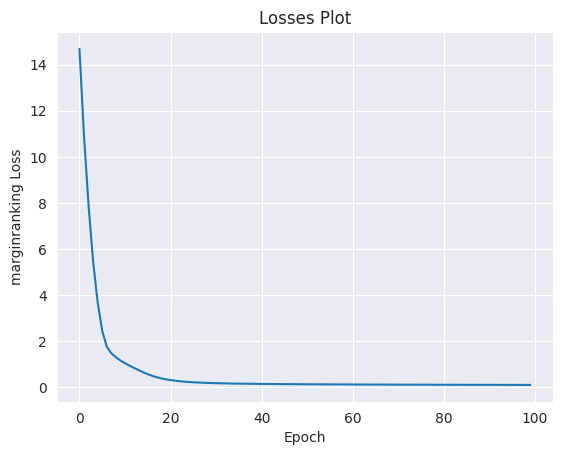

In [15]:
# Обученная модель хранится в pipeline_results
model = pipeline_results.model

#plot loss
pipeline_results.plot_losses()

## Метрики оценки работы модели

В PyKEEN пакет metrics предоставляет реализацию различных метрик, которые могут быть использованы для оценки качества работы моделей знаний (knowledge graph embedding models). Эти метрики позволяют оценивать, насколько хорошо модель справляется с предсказанием троек в графе знаний.

Некоторые из основных метрик, доступных в пакете metrics:

*   Rank-based Metrics - которые измеряют позицию верного ответа (положительной тройки) в отсортированном списке всех возможных троек
*   Top-K Metrics - которые оценивают качество предсказаний в топ-K результатах.
*   Clustering Metrics - которые измеряют качество кластеризации.

Рассчитаем некоторые из них далее.

In [16]:
# Создаем evaluator объект
evaluator = RankBasedEvaluator()

# Оценить работу модели
metrics = evaluator.evaluate(pipeline_results.model, dbpedia_dataset.testing.mapped_triples,
                             additional_filter_triples=[dbpedia_dataset.training.mapped_triples,
                                                        dbpedia_dataset.validation.mapped_triples])

# Print the metrics
print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=1024.


Evaluating on cuda:0:   0%|          | 0.00/49.8k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 19.97s seconds


Hits@1: 0.027369182541596336
Hits@3: 0.06131942769873804
Hits@5: 0.08687002652519894
Hits@10: 0.1370066714894301
Mean Reciprocal Rank: 0.06613826006650925


## Получение представлений узлов

После того как модель обучена, мы можем полчить представления узлов и отношений из результатов работы пайплайна.

In [17]:
node_embeddings = pipeline_results.model.entity_representations

embedding_matrix = node_embeddings[0]._embeddings.weight.data

# Конвертируем матрицу весов в NumPy array
embedding_numpy = embedding_matrix.cpu().numpy()

Мы извлекаем представления узлов из обученной модели. В этом контексте, представления узлов - это векторы, представляющие сущности в графе.

Далее извлечем лейблы для сущнойстей и визуализируем некоторые из сущностей на плоскости.

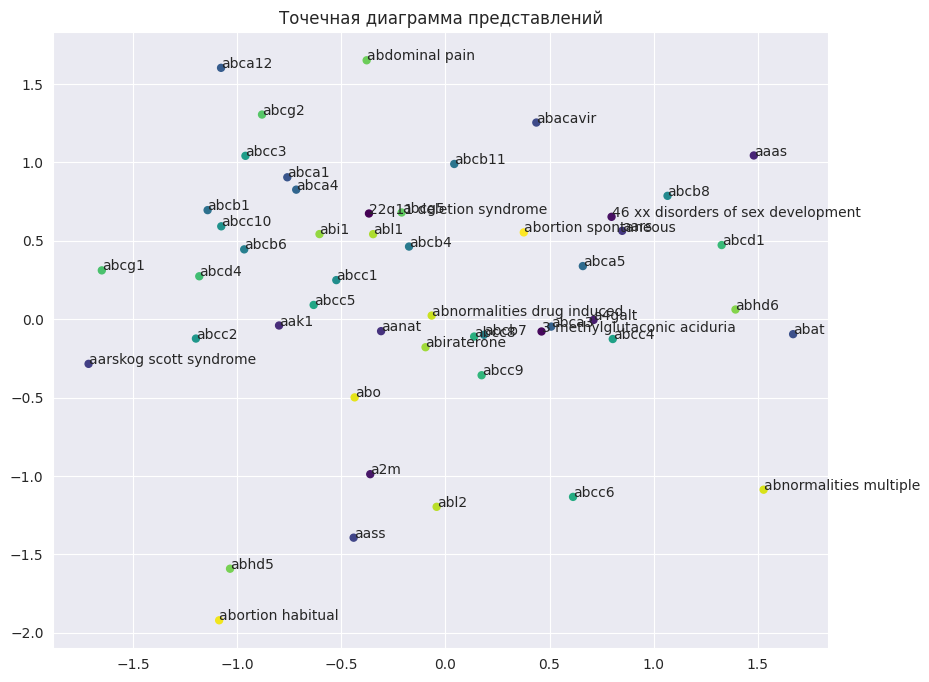

In [18]:
#Созраняем названия сущностей в отдельной переменной
id_to_lable = list(dbpedia_dataset.testing.entity_id_to_label.values())

def visualize_embeddings(embeddings, labels):
    # Scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=np.arange(len(labels)), cmap='viridis', s=25)

    # Добавляем лейблы к точкаи на графике
    for i, label in enumerate(labels):
        plt.annotate(label, (embeddings[i, 0], embeddings[i, 1]), alpha=1)

    plt.title('Точечная диаграмма представлений')
    plt.show()

#Количество точек которые необходимо отобразить на графике
number = 50

visualize_embeddings(embedding_numpy[:number], id_to_lable[:number])

Мы используем NetworkX и Matplotlib для визуализации представлений узлов на графе. Каждая сущность представлена точкой в двумерном пространстве, и близкие точки соответствуют похожим узлам в графе.

## Измерение Node Similarity

Добавим код для измерения близости узлов на основе представлений. Расчитаем близость между несколькими случайными узлами. Используем для этого косинусную схожесть, манхэттенское и евклидово расстояние. Визуализируем полученные результаты как матрицу близости.


[[ 0.       18.175545 22.544046 23.87947 ]
 [18.175545  0.       17.660097 17.298569]
 [22.544046 17.660097  0.       22.29105 ]
 [23.87947  17.298569 22.29105   0.      ]]


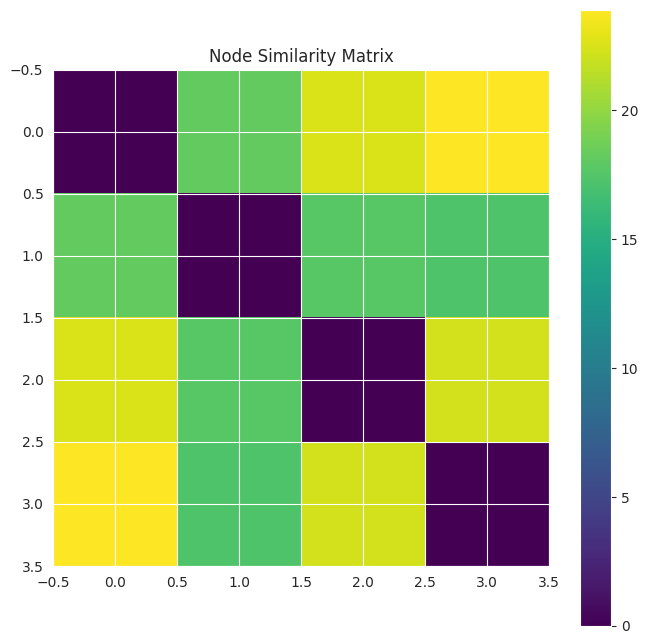

[[ 1.          0.00357274  0.0503858  -0.05469678]
 [ 0.00357274  1.0000002  -0.05374541  0.02853019]
 [ 0.0503858  -0.05374541  1.          0.02485698]
 [-0.05469678  0.02853019  0.02485698  1.0000002 ]]


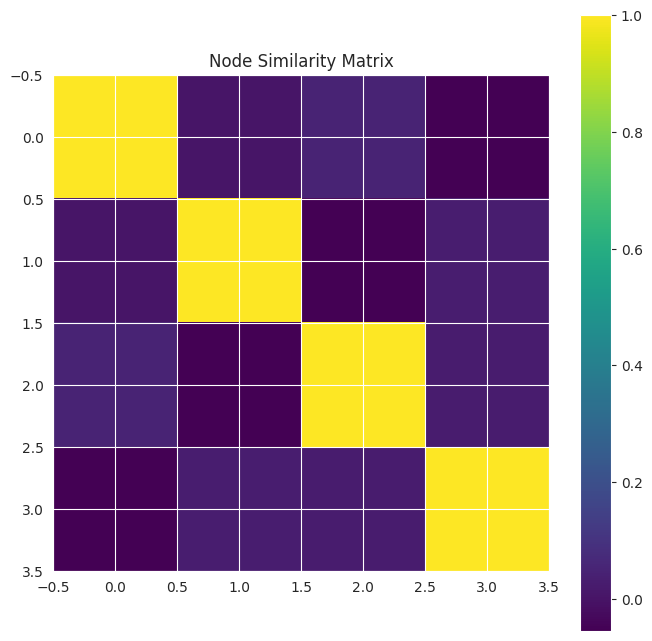

[[  0.         293.02786599 359.67416443 376.53966238]
 [293.02786599   0.         282.92404307 274.69763971]
 [359.67416443 282.92404307   0.         362.98748359]
 [376.53966238 274.69763971 362.98748359   0.        ]]


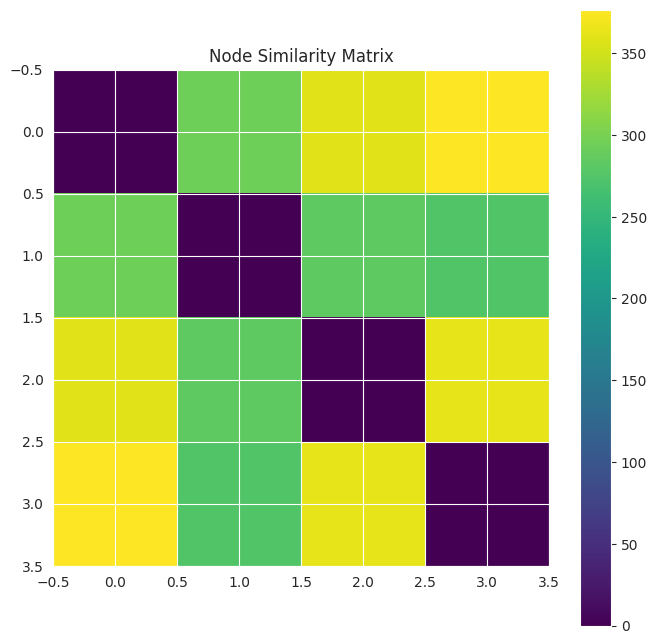

In [19]:
def diplay_matrix(similarity_matrix):
  # Визуализация матрицы близости
  plt.figure(figsize=(8, 8))
  plt.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
  plt.colorbar()
  plt.title('Node Similarity Matrix')
  plt.show()


# Рассчет близости между узлами
methods = [euclidean_distances,cosine_similarity,manhattan_distances]
#Узлы
nodes = [embedding_numpy[67],embedding_numpy[135],embedding_numpy[211],embedding_numpy[267]]
for method in methods:
  similarity_matrix = method(nodes)
  print(similarity_matrix)
  diplay_matrix(similarity_matrix)

Этот код использует euclidean_distances,cosine_similarity и manhattan_distances из scikit-learn для вычисления матрицы близости между узлами на основе их представлений. Затем мы визуализируем эту матрицу для наглядного представления Node Similarity.

## Поиск соседей узла
Одной из задач где используется схожесть узлов является задача поиска ближайших соседей конкретного узла в графе.
Рассмотрии применение NearestNeighbors на созданных представлениях с использованием только что рассмотренных методов рассчета близости.

In [20]:
# Выбираем случайный узел
random_node_index = 270
methods = ['nan_euclidean','cosine','manhattan']
def nearest_nodes(method):
  nn_model = NearestNeighbors(n_neighbors=4, metric=method)
  nn_model.fit(embedding_numpy)
  distances, indices = nn_model.kneighbors([embedding_numpy[random_node_index]])
  print('Метрика:'+method )
  print(f'Дистанции:{distances}' )
  print(f'Индексы:{indices}' )
  # Визуализация ближайших соседей
  neighbors_labels = [id_to_lable[i] for i in indices.flatten()]
  print(f"Ближайшие соседи узла {id_to_lable[random_node_index]}: {neighbors_labels} \n")

for method in methods: nearest_nodes(method)

Метрика:nan_euclidean
Дистанции:[[3.3717478e-07 1.5622801e+01 1.5627710e+01 1.5632672e+01]]
Индексы:[[ 270 3237 4531  327]]
Ближайшие соседи узла aldh6a1: ['aldh6a1', 'hypophosphatemia', 'nepafenac', 'amebiasis'] 

Метрика:cosine
Дистанции:[[1.1920929e-07 7.5560826e-01 7.7922505e-01 7.8025246e-01]]
Индексы:[[ 270  272 4349 4047]]
Ближайшие соседи узла aldh6a1: ['aldh6a1', 'aldh9a1', 'mut', 'mccc2'] 

Метрика:manhattan
Дистанции:[[  0.         246.81797791 247.70606995 247.82977295]]
Индексы:[[ 270  641 2329 4531]]
Ближайшие соседи узла aldh6a1: ['aldh6a1', 'b4galnt1', 'factor xiii deficiency', 'nepafenac'] 



#Изменение количества эпох

In [21]:
# Задаем параметры для pipeline
pipeline_results = pipeline(
    model="ComplEx",
    dataset=dbpedia_dataset,
    training_kwargs=dict(num_epochs=15),
    device=device
)

INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cuda:0:   0%|          | 0/15 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=1024.


Evaluating on cuda:0:   0%|          | 0.00/49.8k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 19.25s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

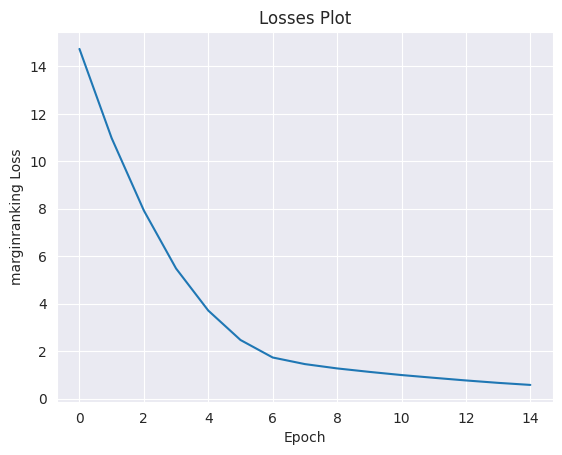

In [22]:
# Обученная модель хранится в pipeline_results
model = pipeline_results.model

#plot loss
pipeline_results.plot_losses()

In [23]:
# Создаем evaluator объект
evaluator = RankBasedEvaluator()

# Оценить работу модели
metrics = evaluator.evaluate(pipeline_results.model, dbpedia_dataset.testing.mapped_triples,
                             additional_filter_triples=[dbpedia_dataset.training.mapped_triples,
                                                        dbpedia_dataset.validation.mapped_triples])

# Print the metrics
print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=1024.


Evaluating on cuda:0:   0%|          | 0.00/49.8k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 19.04s seconds


Hits@1: 0.013493690217828149
Hits@3: 0.018959488787074995
Hits@5: 0.023289928462342256
Hits@10: 0.032453179004903146
Mean Reciprocal Rank: 0.021988429129123688


In [24]:
node_embeddings = pipeline_results.model.entity_representations

embedding_matrix = node_embeddings[0]._embeddings.weight.data

# Конвертируем матрицу весов в NumPy array
embedding_numpy = embedding_matrix.cpu().numpy()

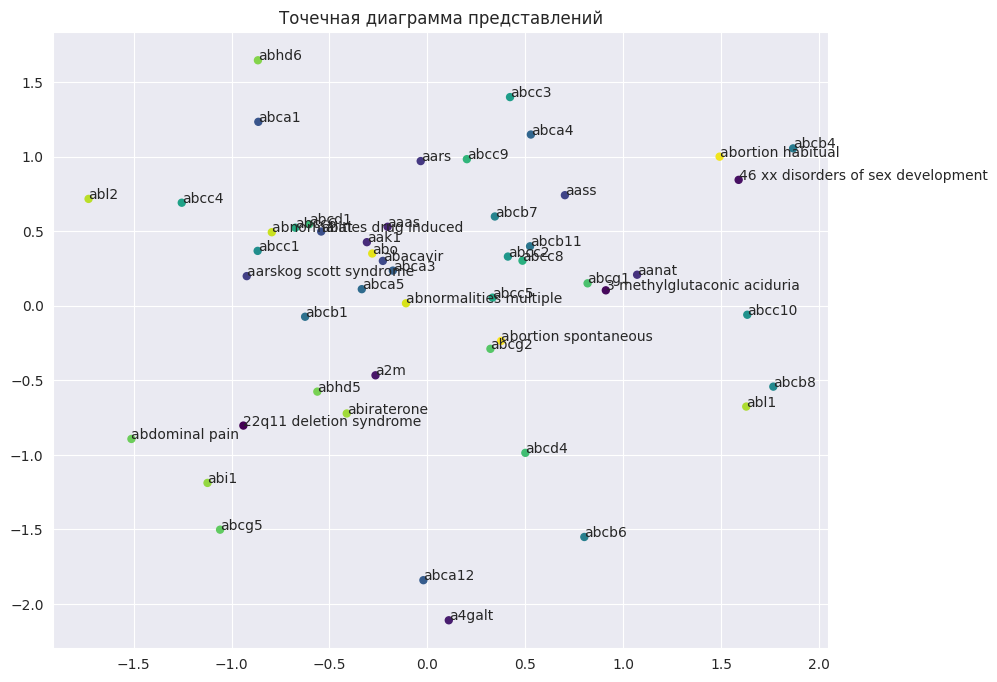

In [25]:
#Созраняем названия сущностей в отдельной переменной
id_to_lable = list(dbpedia_dataset.testing.entity_id_to_label.values())

def visualize_embeddings(embeddings, labels):
    # Scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=np.arange(len(labels)), cmap='viridis', s=25)

    # Добавляем лейблы к точкаи на графике
    for i, label in enumerate(labels):
        plt.annotate(label, (embeddings[i, 0], embeddings[i, 1]), alpha=1)

    plt.title('Точечная диаграмма представлений')
    plt.show()

#Количество точек которые необходимо отобразить на графике
number = 50

visualize_embeddings(embedding_numpy[:number], id_to_lable[:number])

[[ 0.       27.220568 27.201048 27.035559]
 [27.220568  0.       27.876785 28.369091]
 [27.201048 27.876785  0.       26.998268]
 [27.035559 28.369091 26.998268  0.      ]]


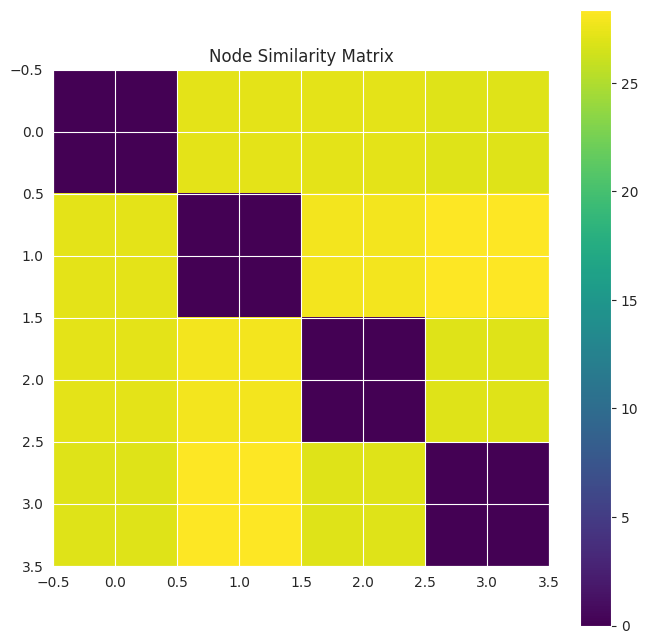

[[ 1.0000001   0.04009634  0.04767552  0.01052307]
 [ 0.04009634  0.99999934  0.02832113 -0.05685847]
 [ 0.04767552  0.02832113  1.0000001   0.04918508]
 [ 0.01052307 -0.05685847  0.04918508  1.0000004 ]]


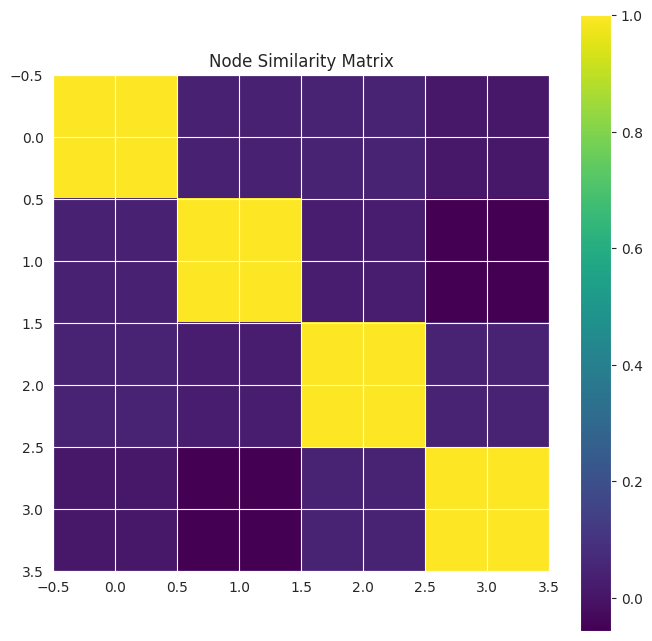

[[  0.         440.52282975 433.63257428 438.98402527]
 [440.52282975   0.         448.8204443  438.94771117]
 [433.63257428 448.8204443    0.         436.37025607]
 [438.98402527 438.94771117 436.37025607   0.        ]]


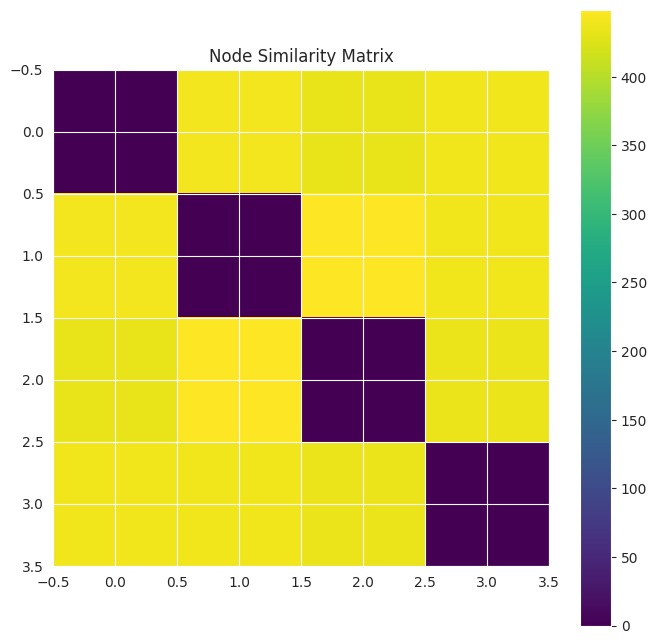

In [26]:
def diplay_matrix(similarity_matrix):
  # Визуализация матрицы близости
  plt.figure(figsize=(8, 8))
  plt.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
  plt.colorbar()
  plt.title('Node Similarity Matrix')
  plt.show()


# Рассчет близости между узлами
methods = [euclidean_distances,cosine_similarity,manhattan_distances]
#Узлы
nodes = [embedding_numpy[67],embedding_numpy[135],embedding_numpy[211],embedding_numpy[267]]
for method in methods:
  similarity_matrix = method(nodes)
  print(similarity_matrix)
  diplay_matrix(similarity_matrix)

In [27]:
# Выбираем случайный узел
random_node_index = 270
methods = ['nan_euclidean','cosine','manhattan']
def nearest_nodes(method):
  nn_model = NearestNeighbors(n_neighbors=4, metric=method)
  nn_model.fit(embedding_numpy)
  distances, indices = nn_model.kneighbors([embedding_numpy[random_node_index]])
  print('Метрика:'+method )
  print(f'Дистанции:{distances}' )
  print(f'Индексы:{indices}' )
  # Визуализация ближайших соседей
  neighbors_labels = [id_to_lable[i] for i in indices.flatten()]
  print(f"Ближайшие соседи узла {id_to_lable[random_node_index]}: {neighbors_labels} \n")

for method in methods: nearest_nodes(method)

Метрика:nan_euclidean
Дистанции:[[ 0.       23.161394 24.090183 24.095552]]
Индексы:[[ 270 4521 6034 6480]]
Ближайшие соседи узла aldh6a1: ['aldh6a1', 'neoplasms', 'sh3bp2', 'sulfinpyrazone'] 

Метрика:cosine
Дистанции:[[1.1920929e-07 8.3702922e-01 8.4075922e-01 8.4361428e-01]]
Индексы:[[ 270 2784 1310  114]]
Ближайшие соседи узла aldh6a1: ['aldh6a1', 'gna13', 'chrnb1', 'actn2'] 

Метрика:manhattan
Дистанции:[[  0.         369.13946533 379.76550293 380.46313477]]
Индексы:[[ 270 4521 4409 6186]]
Ближайшие соседи узла aldh6a1: ['aldh6a1', 'neoplasms', 'nabilone', 'slc35d1'] 



#Изменяем модель

In [28]:
# Задаем параметры для pipeline
pipeline_results = pipeline(
    model="Hole",
    dataset=dbpedia_dataset,
    training_kwargs=dict(num_epochs=15),
    device=device
)

INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cuda:0:   0%|          | 0/15 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1511 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=256.


Evaluating on cuda:0:   0%|          | 0.00/49.8k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 41.37s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

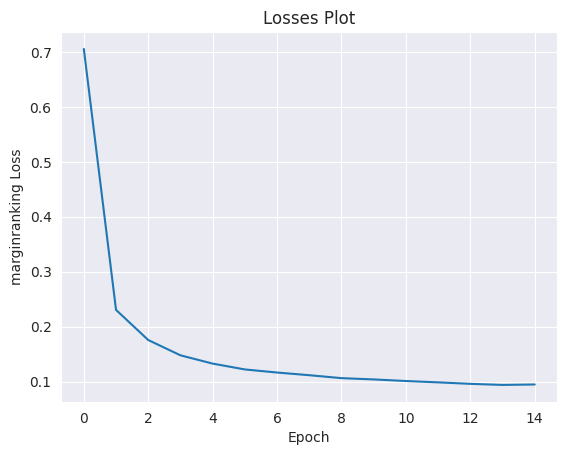

In [29]:
# Обученная модель хранится в pipeline_results
model = pipeline_results.model

#plot loss
pipeline_results.plot_losses()

In [30]:
# Создаем evaluator объект
evaluator = RankBasedEvaluator()

# Оценить работу модели
metrics = evaluator.evaluate(pipeline_results.model, dbpedia_dataset.testing.mapped_triples,
                             additional_filter_triples=[dbpedia_dataset.training.mapped_triples,
                                                        dbpedia_dataset.validation.mapped_triples])

# Print the metrics
print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=256.


Evaluating on cuda:0:   0%|          | 0.00/49.8k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 41.03s seconds


Hits@1: 0.029750421991801303
Hits@3: 0.07245197331404228
Hits@5: 0.10179045092838196
Hits@10: 0.15432843019049916
Mean Reciprocal Rank: 0.0743572786450386


In [31]:
node_embeddings = pipeline_results.model.entity_representations

embedding_matrix = node_embeddings[0]._embeddings.weight.data

# Конвертируем матрицу весов в NumPy array
embedding_numpy = embedding_matrix.cpu().numpy()

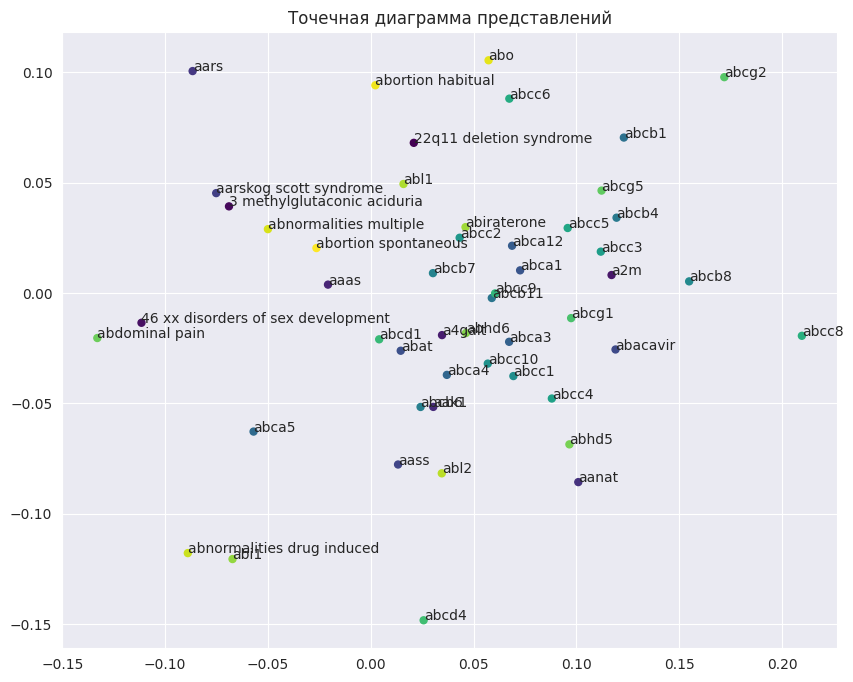

In [32]:
#Созраняем названия сущностей в отдельной переменной
id_to_lable = list(dbpedia_dataset.testing.entity_id_to_label.values())

def visualize_embeddings(embeddings, labels):
    # Scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=np.arange(len(labels)), cmap='viridis', s=25)

    # Добавляем лейблы к точкаи на графике
    for i, label in enumerate(labels):
        plt.annotate(label, (embeddings[i, 0], embeddings[i, 1]), alpha=1)

    plt.title('Точечная диаграмма представлений')
    plt.show()

#Количество точек которые необходимо отобразить на графике
number = 50

visualize_embeddings(embedding_numpy[:number], id_to_lable[:number])

[[0.        1.3782539 1.4884834 1.3911582]
 [1.3782539 0.        1.4011909 1.4360238]
 [1.4884834 1.4011909 0.        1.4108024]
 [1.3911582 1.4360238 1.4108024 0.       ]]


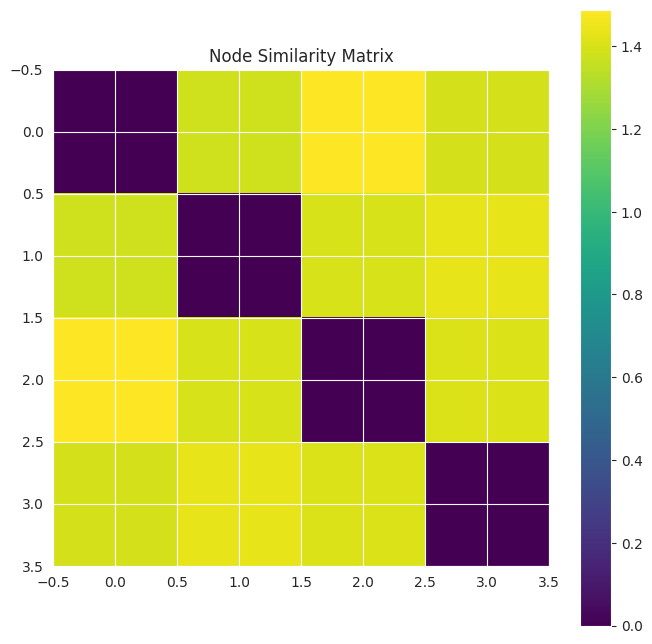

[[ 9.9999982e-01  4.0918190e-04 -1.7054345e-01 -1.8422175e-02]
 [ 4.0918190e-04  1.0000001e+00  1.4760517e-02 -3.1082315e-02]
 [-1.7054345e-01  1.4760517e-02  1.0000001e+00  1.1973974e-03]
 [-1.8422175e-02 -3.1082315e-02  1.1973974e-03  1.0000001e+00]]


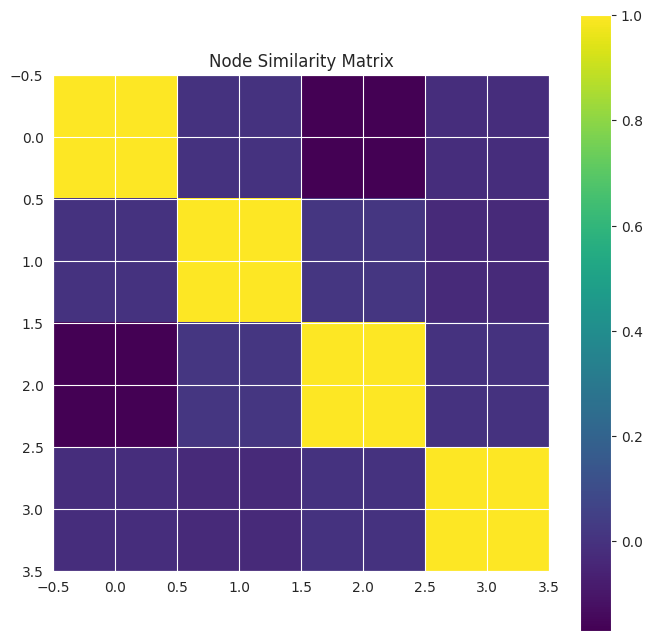

[[ 0.         15.33037288 16.81253382 15.76500677]
 [15.33037288  0.         15.97420458 16.0916528 ]
 [16.81253382 15.97420458  0.         15.55178097]
 [15.76500677 16.0916528  15.55178097  0.        ]]


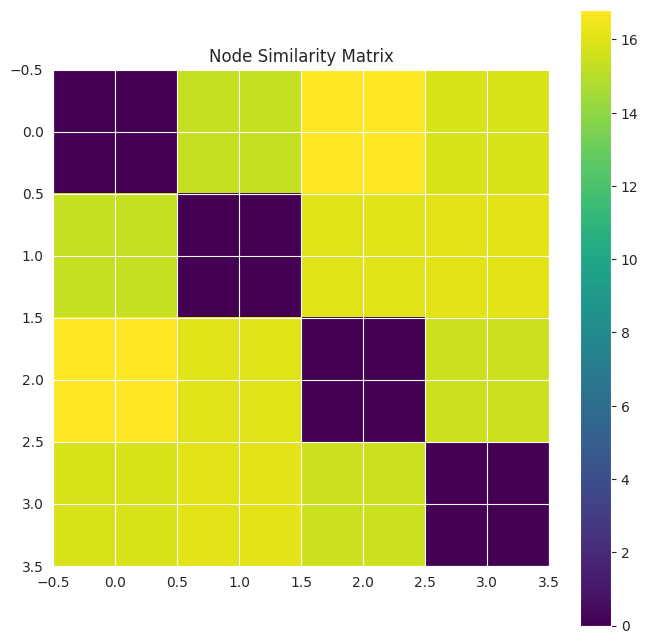

In [33]:
def diplay_matrix(similarity_matrix):
  # Визуализация матрицы близости
  plt.figure(figsize=(8, 8))
  plt.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
  plt.colorbar()
  plt.title('Node Similarity Matrix')
  plt.show()


# Рассчет близости между узлами
methods = [euclidean_distances,cosine_similarity,manhattan_distances]
#Узлы
nodes = [embedding_numpy[67],embedding_numpy[135],embedding_numpy[211],embedding_numpy[267]]
for method in methods:
  similarity_matrix = method(nodes)
  print(similarity_matrix)
  diplay_matrix(similarity_matrix)

In [34]:
# Выбираем случайный узел
random_node_index = 270
methods = ['nan_euclidean','cosine','manhattan']
def nearest_nodes(method):
  nn_model = NearestNeighbors(n_neighbors=4, metric=method)
  nn_model.fit(embedding_numpy)
  distances, indices = nn_model.kneighbors([embedding_numpy[random_node_index]])
  print('Метрика:'+method )
  print(f'Дистанции:{distances}' )
  print(f'Индексы:{indices}' )
  # Визуализация ближайших соседей
  neighbors_labels = [id_to_lable[i] for i in indices.flatten()]
  print(f"Ближайшие соседи узла {id_to_lable[random_node_index]}: {neighbors_labels} \n")

for method in methods: nearest_nodes(method)

Метрика:nan_euclidean
Дистанции:[[0.         0.98814744 1.0017223  1.0067766 ]]
Индексы:[[ 270 5932  106  528]]
Ближайшие соседи узла aldh6a1: ['aldh6a1', 'scly', 'acss3', 'asl'] 

Метрика:cosine
Дистанции:[[0.         0.49230528 0.50172377 0.5078995 ]]
Индексы:[[ 270 5932  106  363]]
Ближайшие соседи узла aldh6a1: ['aldh6a1', 'scly', 'acss3', 'amt'] 

Метрика:manhattan
Дистанции:[[ 0.         11.0833931  11.19123936 11.33113861]]
Индексы:[[ 270 5932  106 1621]]
Ближайшие соседи узла aldh6a1: ['aldh6a1', 'scly', 'acss3', 'cth'] 



In [35]:
# Выбираем случайный узел
random_node_index = 1568
methods = ['nan_euclidean','cosine','manhattan']
def nearest_nodes(method):
  nn_model = NearestNeighbors(n_neighbors=4, metric=method)
  nn_model.fit(embedding_numpy)
  distances, indices = nn_model.kneighbors([embedding_numpy[random_node_index]])
  print('Метрика:'+method )
  print(f'Дистанции:{distances}' )
  print(f'Индексы:{indices}' )
  # Визуализация ближайших соседей
  neighbors_labels = [id_to_lable[i] for i in indices.flatten()]
  print(f"Ближайшие соседи узла {id_to_lable[random_node_index]}: {neighbors_labels} \n")

for method in methods: nearest_nodes(method)

Метрика:nan_euclidean
Дистанции:[[0.        1.091409  1.1073214 1.1120199]]
Индексы:[[1568 5058 5060 5059]]
Ближайшие соседи узла crot: ['crot', 'pex16', 'pex26', 'pex19'] 

Метрика:cosine
Дистанции:[[0.         0.60179085 0.61946833 0.6247369 ]]
Индексы:[[1568 5058 5060 5059]]
Ближайшие соседи узла crot: ['crot', 'pex16', 'pex26', 'pex19'] 

Метрика:manhattan
Дистанции:[[ 0.         12.59258366 12.67642975 12.68369579]]
Индексы:[[1568 5058 5060 5055]]
Ближайшие соседи узла crot: ['crot', 'pex16', 'pex26', 'pex12'] 

